# Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from bisect import bisect
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
##################
# FULL OPA
##################

downpayment = 0.20     # percent of price
interest = 0.055       # percent of price
mortgage_duration = 30 # years
rofr = 0.1             # percent reduction in sales price
spillover_amt = 0.4    # percent of sales that are affected by spillover
spillover_mag = 0.1    # reduction of sale price due to spillover
off_market = 0.1       # percent of sales off markett
dti = 0.36             # debt-to-income ratio that's required to get the mortgage approved
ami = 149_600          # average median income
sfh = 1                # include single family homes in OPA? 1 = yes, 0 = no

# Read data

In [8]:
df = pd.read_csv('final_results_1000.csv')

In [9]:
df.columns = [c.lower().replace(' ', '_') for c in df.columns]

n = len(df)
sim_ids = set(df.simulation)
num_sims = len(sim_ids)
num_per_sim = n / num_sims

# Computation

In [10]:
def get_category_coarse(x):
    idx = bisect([80, 160], x)
    cats = ['Low Income', 'Middle Income', 'Upper Income']
    return cats[idx]

df['adj_price'] = df.price
df['adj_price'] = df.adj_price - (np.random.random(n) < spillover_amt) * spillover_mag * df.price

df['p_ami'] = df.income / ami * 100
df['mortgage'] = (1 - downpayment) * ((1 + interest) ** mortgage_duration) * (1 - rofr) * df.adj_price / mortgage_duration
df['viable'] = (df.mortgage / df.income <= dti) 

# 0 = not eligible, 1 = still eligible
df['eligible_market'] = 1 - (np.random.random(n) < off_market)
df['eligible_sfh'] = np.ones(n) if sfh == 1 else (df.property_indicator != 10) * 1

df['viable_eligible'] = df.eligible_market * df.eligible_sfh * df.viable
df['income_category'] = df.p_ami.apply(get_category_coarse)


# Results

In [11]:
ve = df.groupby('simulation').mean().viable_eligible
m, s = ve.mean(), ve.std()

print(f'viable & eligible: {m:.2%}')
print(f'95% confidence interval (viable & eligible): {m - 2*s:.2%}, {m + 2*s:.2%}')

viable & eligible: 9.87%
95% confidence interval (viable & eligible): 7.54%, 12.20%


## Optimization strategies

In [12]:
def count_sum_to_thresh(df, thresh):
    a = df.gap
    for i in range(len(a)):
        if sum(a[:i]) > thresh:
            break
    num_helped = i - 1

    return num_helped, df.iloc[:num_helped]

def count_sum_to_thresh_thanos(a, thresh, full_df):
    for i in range(len(a)):
        if sum(a[:i]) > thresh:
            break
    num_helped = i - 1

    return num_helped, full_df.iloc[:num_helped]

In [13]:
def surgical(funding):
    potential = df[df.eligible_market * df.eligible_sfh == 1]
    potential = potential[potential.viable_eligible == 0]
    potential['gap'] = potential.mortgage / dti - potential.income
    
    num_helped = []
    people_helped = []

    for sid in sim_ids:
        x = potential[potential.simulation == sid]
        x = x.sort_values('gap')
        nh, ph = count_sum_to_thresh(x, funding)

        num_helped.append(nh)
        people_helped.append(ph)

    num_helped = np.array(num_helped)
    people_helped = pd.concat(people_helped)

    return num_helped, people_helped


def surgical_equitable(funding):
    potential = df[df.eligible_market * df.eligible_sfh == 1]
    potential = potential[potential.viable_eligible == 0]
    potential['gap'] = potential.mortgage / dti - potential.income
    
    num_helped = []
    people_helped = []

    for sid in sim_ids:
        x = potential[potential.simulation == sid]
        x = x[x.p_ami < 80]
        x = x.sort_values('gap')

        nh, ph = count_sum_to_thresh(x, funding)

        num_helped.append(nh)
        people_helped.append(ph)

    num_helped = np.array(num_helped)
    people_helped = pd.concat(people_helped)

    return num_helped, people_helped


def thanos(funding):
    potential = df[df.eligible_market * df.eligible_sfh == 1]
    potential = potential[potential.viable_eligible == 0]
    potential['gap'] = potential.mortgage / dti - potential.income

    num_helped = []
    people_helped = []

    for sid in sim_ids:
        x = potential[potential.simulation == sid]
        x = x.sample(frac=0.5)  # thanos
        x = x.sort_values('gap')
        a = x.gap
        a = a / 0.63  # https://web.archive.org/web/20200321115234id_/https://www.innovations.harvard.edu/sites/default/files/hpd_0202_stegman.pdf

        nh, ph = count_sum_to_thresh_thanos(a, funding, x)

        num_helped.append(nh)
        people_helped.append(ph)

    num_helped = np.array(num_helped)
    people_helped = pd.concat(people_helped)

    return num_helped, people_helped


def thanos_equitable(funding):
    potential = df[df.eligible_market * df.eligible_sfh == 1]
    potential = potential[potential.viable_eligible == 0]
    potential['gap'] = potential.mortgage / dti - potential.income

    num_helped = []
    people_helped = []

    for sid in sim_ids:
        x = potential[potential.simulation == sid]
        x = x[x.p_ami < 80]
        x = x.sample(frac=0.5)  # thanos
        x = x.sort_values('gap')
        a = x.gap
        a = a / 0.63  # https://web.archive.org/web/20200321115234id_/https://www.innovations.harvard.edu/sites/default/files/hpd_0202_stegman.pdf

        nh, ph = count_sum_to_thresh_thanos(a, funding, x)

        num_helped.append(nh)
        people_helped.append(ph)

    num_helped = np.array(num_helped)
    people_helped = pd.concat(people_helped)

    return num_helped, people_helped

In [14]:
funding_options = [0, 2_000_000, 5_000_000, 10_000_000, 20_000_000, 50_000_000]

In [15]:
d = {
    'funding': funding_options,
    'Theoretical': [surgical(f) for f in funding_options],
    'Theoretical (Equitable Focus)': [surgical_equitable(f) for f in funding_options],
    'Realistic': [thanos(f) for f in funding_options],
    'Realistic (Equitable Focus)': [thanos_equitable(f) for f in funding_options]
}

## Plotting

In [16]:
keys = ('Theoretical',
        'Theoretical (Equitable Focus)', 
        'Realistic', 
        'Realistic (Equitable Focus)')


### Overall number

In [17]:
overall = {
  'funding': funding_options
}

baseline = df.groupby('simulation').viable_eligible.sum().mean()

for k in keys:
  # average results across simulations
  overall[k] = [baseline + res[0].mean() for res in d[k]]

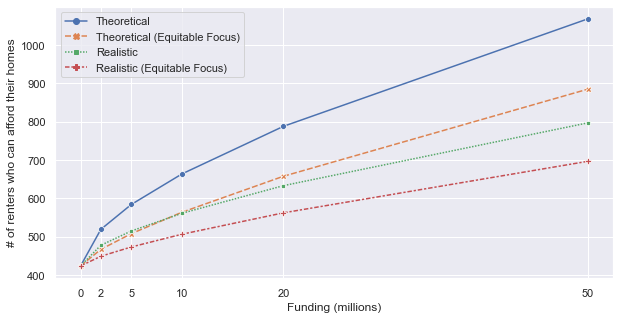

In [18]:
plt.rcParams['figure.figsize'] = [10, 5]

sns.set_theme()
sns.lineplot(data=pd.DataFrame(overall).set_index('funding'), markers=True)

plt.xlabel('Funding (millions)')
plt.ylabel('# of renters who can afford their homes')
plt.gcf().patch.set_facecolor('white')
plt.xticks(funding_options)
plt.gca().set_xticklabels(['0', '2', '5', '10', '20', '50'])

plt.savefig('graphs/overall.png', dpi=300, bbox_inches='tight')

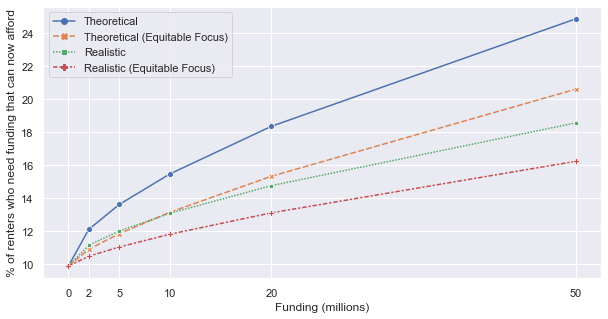

In [19]:
plt.rcParams['figure.figsize'] = [10, 5]

sns.set_theme()
sns.lineplot(data=pd.DataFrame(overall).set_index('funding') / num_per_sim * 100, markers=True)

plt.xlabel('Funding (millions)')
plt.ylabel('% of renters who need funding that can now afford')
plt.gcf().patch.set_facecolor('white')
plt.xticks(funding_options)
plt.gca().set_xticklabels(['0', '2', '5', '10', '20', '50'])

plt.savefig('graphs/overall_percent.png', dpi=300, bbox_inches='tight')

### Equity focused

In [20]:
def perc_low_income(people_helped, full_df):
    try:
        num_low_income_helped = people_helped.income_category.value_counts()['Low Income']
    except KeyError:
        num_low_income_helped = 0
        
    num_low_income_afford = sum((full_df.viable_eligible == 1) & (full_df.income_category == 'Low Income'))
    total_low_income = sum(full_df.income_category == 'Low Income')
    return (num_low_income_afford + num_low_income_helped) / total_low_income

def num_low_income(people_helped, full_df):
    try:
        num_low_income_helped = people_helped.income_category.value_counts()['Low Income']
    except KeyError:
        num_low_income_helped = 0
        
    num_low_income_afford = sum((full_df.viable_eligible == 1) & (full_df.income_category == 'Low Income'))

    return (num_low_income_afford + num_low_income_helped) / num_sims

In [21]:
equity = {
    'funding': funding_options
}

for k in keys:
  # average results across simulations
  # equity[k] = [perc_low_income(res[1], df) for res in d[k]]
  equity[k] = [num_low_income(res[1], df) for res in d[k]]


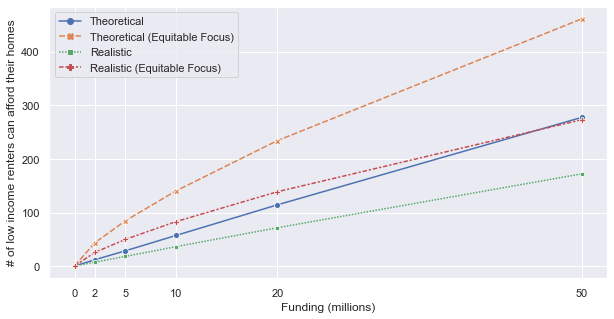

In [22]:
plt.rcParams['figure.figsize'] = [10, 5]

sns.set_theme()
sns.lineplot(data=pd.DataFrame(equity).set_index('funding'), markers=True)

plt.xlabel('Funding (millions)')
plt.ylabel('# of low income renters can afford their homes')
plt.gcf().patch.set_facecolor('white')
plt.xticks(funding_options)
plt.gca().set_xticklabels(['0', '2', '5', '10', '20', '50'])

plt.savefig('graphs/equity_num.png', dpi=300, bbox_inches='tight')

### Funding across policies

In [23]:
do_nothing = np.array([311.8, 351.286, 379.88, 416.194, 473.608, 606.793])
m_elg_bump = np.array([1.633, 9.942, 12.817, 12.817, 12.817, 12.817])
policies = {
    'funding': [0, 2_000_000, 5_000_000, 10_000_000, 20_000_000, 50_000_000],
    'Do nothing': do_nothing,
    'Full OPA': [424.237, 478.071, 515.481, 561.663, 633.5360000000001, 796.749],
    'OPA without ROFR': [378.568, 421.989, 453.009, 492.131, 553.989, 696.106],
    'OPA with restricted eligibility': do_nothing + m_elg_bump,
}

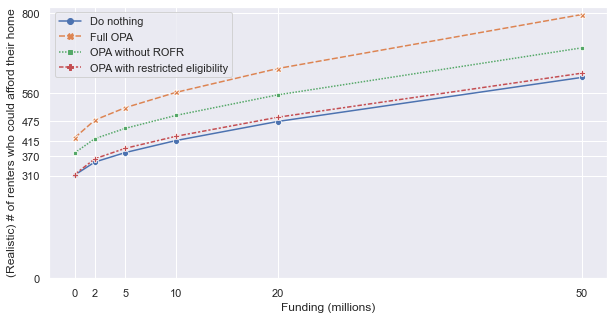

In [24]:
plt.rcParams['figure.figsize'] = [10, 5]

sns.set_theme()
sns.lineplot(data=pd.DataFrame(policies).set_index('funding'), markers=True)

plt.xlabel('Funding (millions)')
plt.ylabel('(Realistic) # of renters who could afford their home')
plt.gcf().patch.set_facecolor('white')
plt.yticks([0, 310, 370, 415, 475, 560, 800])
plt.xticks([0, 2_000_000, 5_000_000, 10_000_000, 20_000_000, 50_000_000])
plt.gca().set_xticklabels(['0', '2', '5', '10', '20', '50'])

plt.savefig('graphs/policies.png', dpi=300, bbox_inches='tight')